# Load the libraries

In [528]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [529]:
#%%javascript
#require("notebook/js/notebook").Notebook.prototype.scroll_to_bottom = function () {}

## Deactivate scrolling window output, it s so annoying! 

In [530]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# PART ONE
# Understanding of the flows of customers across types and ages of titles


Load the dataset with cohort who started in Oct 2017
<br> </br>
There were 184k new customers



Descr: load data with first purchase by type and age and check repeat transactions by age and type

In [531]:
ch = pd.read_csv("../new/data/since_May.txt", sep="\t",
                names = ['customer_Id','start_month','type','age', 'first_price', 'returning_month',
                        'repeat_type','repeat_age','transaction_date_local','repeat_price'])

In [532]:
print(ch.shape)
ch[0:10]

(3036263, 10)


,customer_Id,start_month,type,age,first_price,returning_month,repeat_type,repeat_age,transaction_date_local,repeat_price
0,6459663625,2017-05-01,Movie,Deep Catalogue,8.99,2017-05-01,Movie,Recent release,2017-05-03,4.99
1,390157742,2017-05-01,Movie,1_2yr_Catalogue,12.99,2017-05-01,Movie,Deep Catalogue,2017-05-06,2.99
2,20323413035,2017-05-01,Movie,2_3yr_Catalogue,2.99,2017-05-01,Movie,2_3yr_Catalogue,2017-05-07,2.99
3,363952192,2017-05-01,Movie,Deep Catalogue,2.99,2017-05-01,Movie,Deep Catalogue,2017-05-07,3.99
4,11894215225,2017-05-01,Movie,1_2yr_Catalogue,13.99,2017-05-01,Movie,Recent release,2017-05-07,4.99
5,413578842,2017-05-01,Movie,New Release,4.99,2017-05-01,Movie,6mo_1yr_Catalogue,2017-05-07,6.99
6,1207699512,2017-05-01,TV Episode,New Release,2.99,2017-05-01,TV Season,Recent release,2017-05-08,29.00
7,413578842,2017-05-01,Movie,New Release,4.99,2017-05-01,Movie,2_3yr_Catalogue,2017-05-08,3.99
8,413578842,2017-05-01,Movie,New Release,4.99,2017-05-01,Movie,Recent release,2017-05-08,4.99
9,9762150935,2017-05-01,TV Episode,New Release,2.99,2017-05-01,TV Episode,New Release,2017-05-09,2.49


In [533]:
#Check for Oct
ch[ch['start_month'] == '2017-10-01']['customer_Id'].nunique()

184345

In [549]:
print(ch[ch['customer_Id'] == 363952192].sort_values(by = 'transaction_date_local').shape)
ch[ch['customer_Id'] == 363952192].sort_values(by = 'transaction_date_local')

(5, 12)


,customer_Id,start_month,type,age,first_price,returning_month,repeat_type,repeat_age,transaction_date_local,repeat_price,last2from_repeat,on_promo
3,363952192,2017-05-01,Movie,Deep Catalogue,2.99,2017-05-01,Movie,Deep Catalogue,2017-05-07,3.99,0.99,not_promo
27,363952192,2017-05-01,Movie,Deep Catalogue,2.99,2017-05-01,Movie,Deep Catalogue,2017-05-14,3.99,0.99,not_promo
191,363952192,2017-05-01,Movie,Deep Catalogue,2.99,2017-06-01,Movie,Deep Catalogue,2017-06-05,3.99,0.99,not_promo
2553,363952192,2017-05-01,Movie,Deep Catalogue,2.99,2017-08-01,Movie,6mo_1yr_Catalogue,2017-08-02,9.98,0.98,on_promo
9084,363952192,2017-05-01,Movie,Deep Catalogue,2.99,2017-08-01,TV Season,New Release,2017-08-16,19.99,0.99,not_promo


In [535]:
age_first = pd.DataFrame(ch.groupby("age")['customer_Id'].nunique().reset_index())

In [538]:
age_first['pcts'] = age_first['customer_Id'] / age_first['customer_Id'].sum()
age_first.head()

,age,customer_Id,pcts
0,1_2yr_Catalogue,159211,0.136364
1,2_3yr_Catalogue,153735,0.131674
2,6mo_1yr_Catalogue,94641,0.081060
3,Deep Catalogue,260182,0.222846
4,New Release,201509,0.172592


Distribution of age of content new customers buy


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2239EB668>], dtype=object)

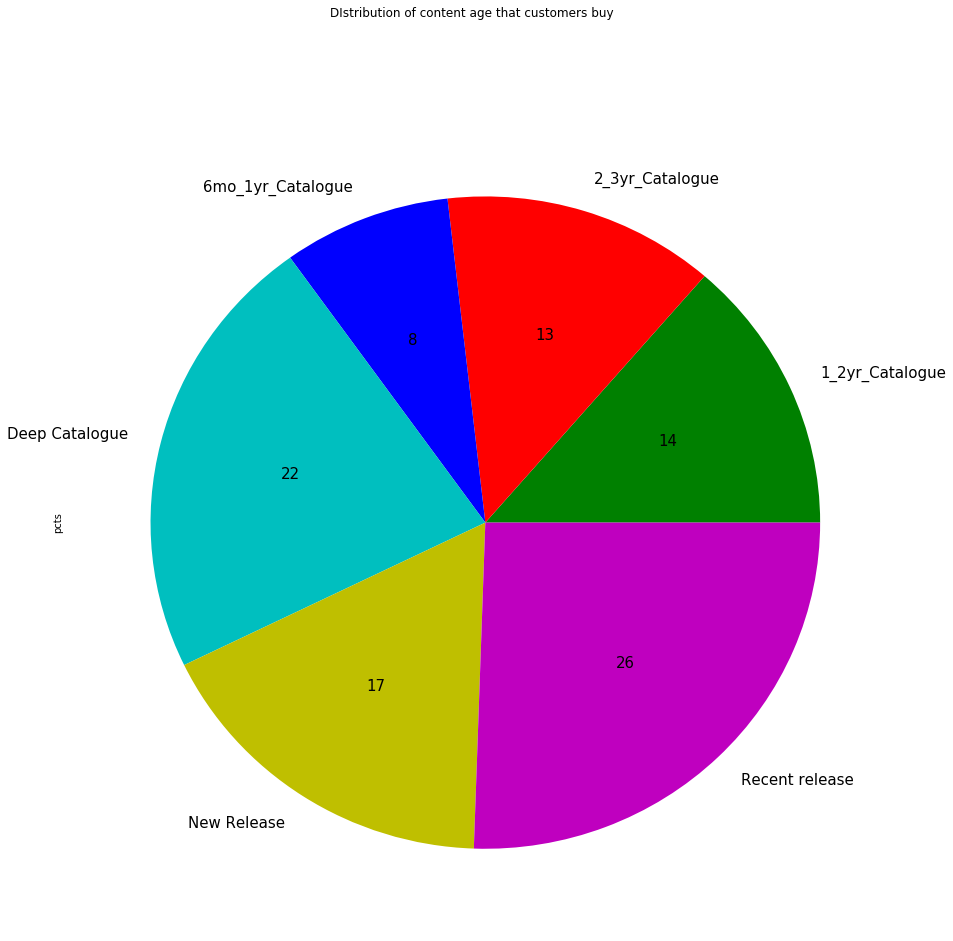

In [539]:
print("Distribution of age of content new customers buy")
#https://matplotlib.org/api/colors_api.html color here
age_first['pcts'].plot.pie(subplots=True, figsize=(15, 15), colors=['g', 'r', 'b', 'c','y','m'],
                           labels= age_first.age, autopct='%.0f',
                           title='DIstribution of content age that customers buy',fontsize=15)

# PART TWO
# Understand what customer buy on repeat basis

In [540]:
def preparation(file):
    p = pd.DataFrame(file.groupby(['returning_month','age','repeat_age'])['customer_Id'].size().reset_index())
    all_month = pd.DataFrame(file.groupby(['returning_month','age'])['customer_Id'].size().reset_index())
    res = pd.merge(left=p,right=all_month,left_on=['returning_month','age'],right_on=['returning_month','age'],how='left')
    res['per'] = res['customer_Id_x'] / res['customer_Id_y']
    return res

In [541]:
p = preparation(ch)

In [498]:
#d = p[p['returning_month'] == '2017-11-01'] #Select returning month
#for title, group in d.groupby('age'):
#    group.plot.bar(x='repeat_age', y='per', title=title,figsize = (20,10))

## Work with repeat price

The flag is the following: if the price is X.98 then promo, and no promo otherwise

In [542]:
def preparation_on_promo(file):
    
    file['last2from_repeat'] = file['repeat_price'].apply(lambda x: round(math.modf(x)[0],2))
    file['on_promo'] = np.where(file['last2from_repeat'] == 0.98,'on_promo','not_promo')
    p = pd.DataFrame(file.groupby(['returning_month','age','repeat_age','on_promo'])['customer_Id'].size().reset_index())
    all_month = pd.DataFrame(file.groupby(['returning_month','age'])['customer_Id'].size().reset_index())
    res = pd.merge(left=p,right=all_month,left_on=['returning_month','age'],right_on=['returning_month','age'],how='left')
    res['per'] = res['customer_Id_x'] / res['customer_Id_y']
    return res 

In [543]:
t = preparation_on_promo(ch)

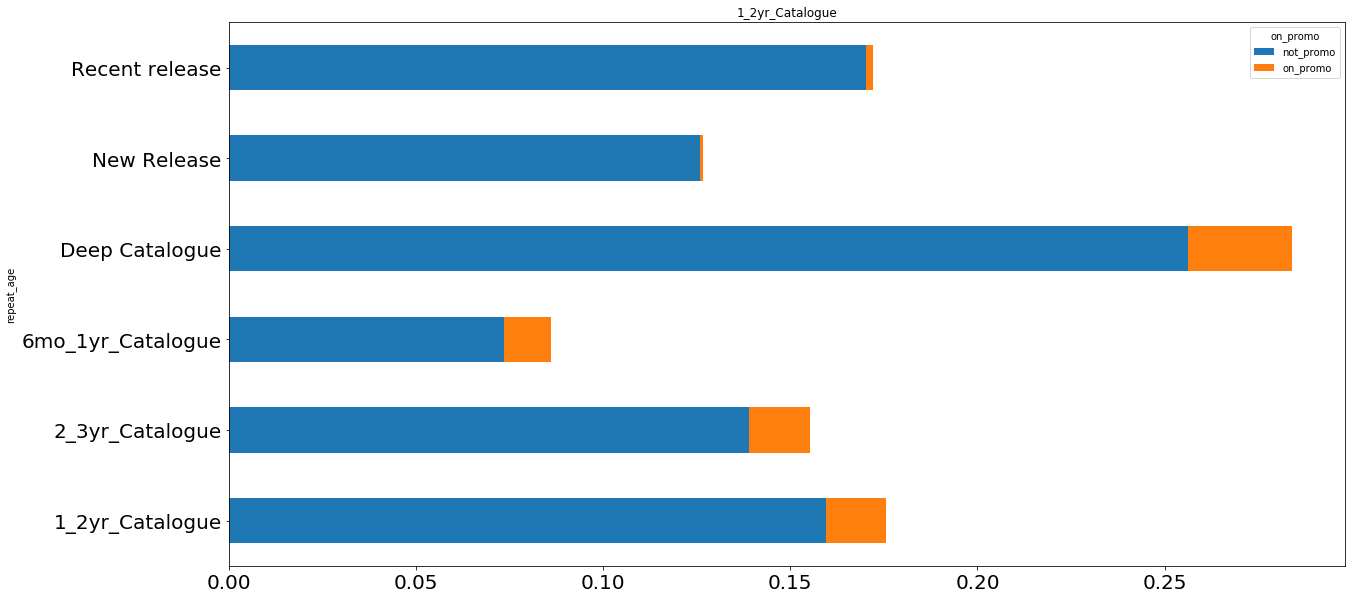

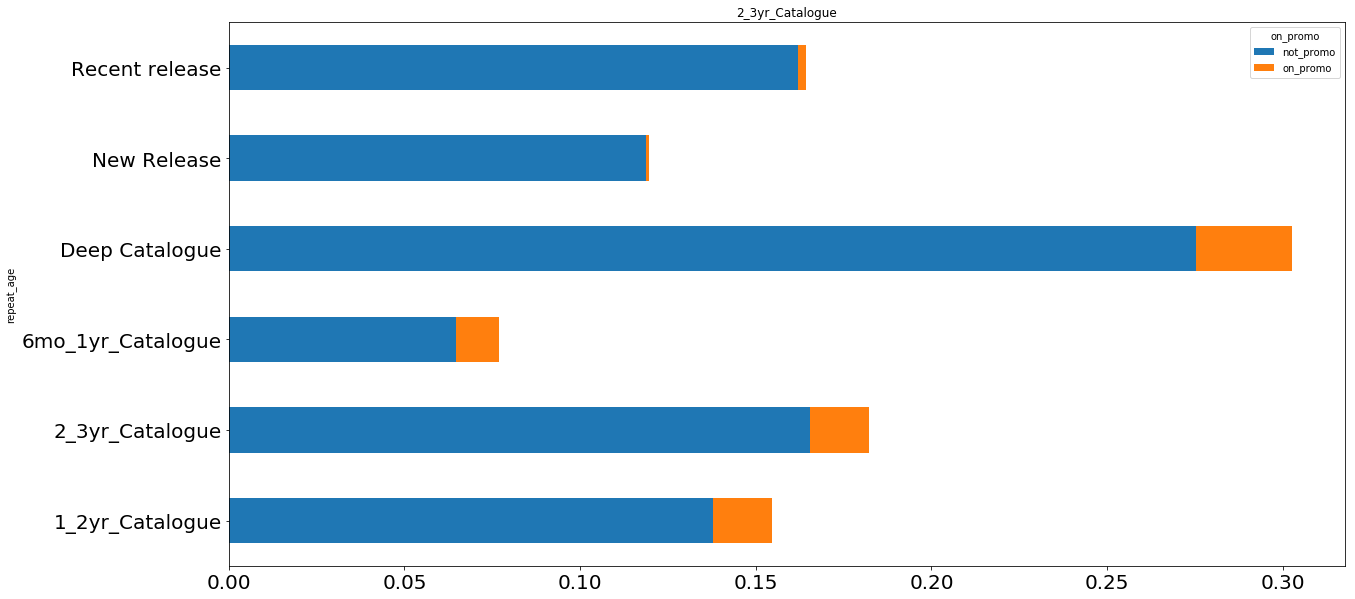

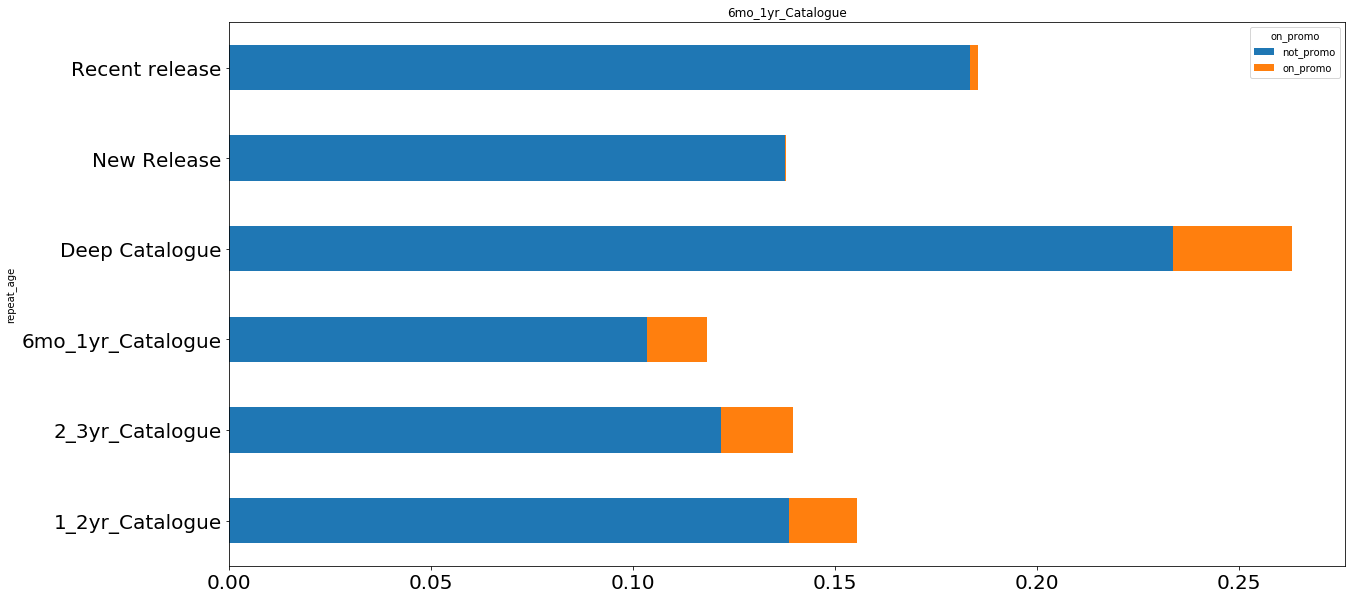

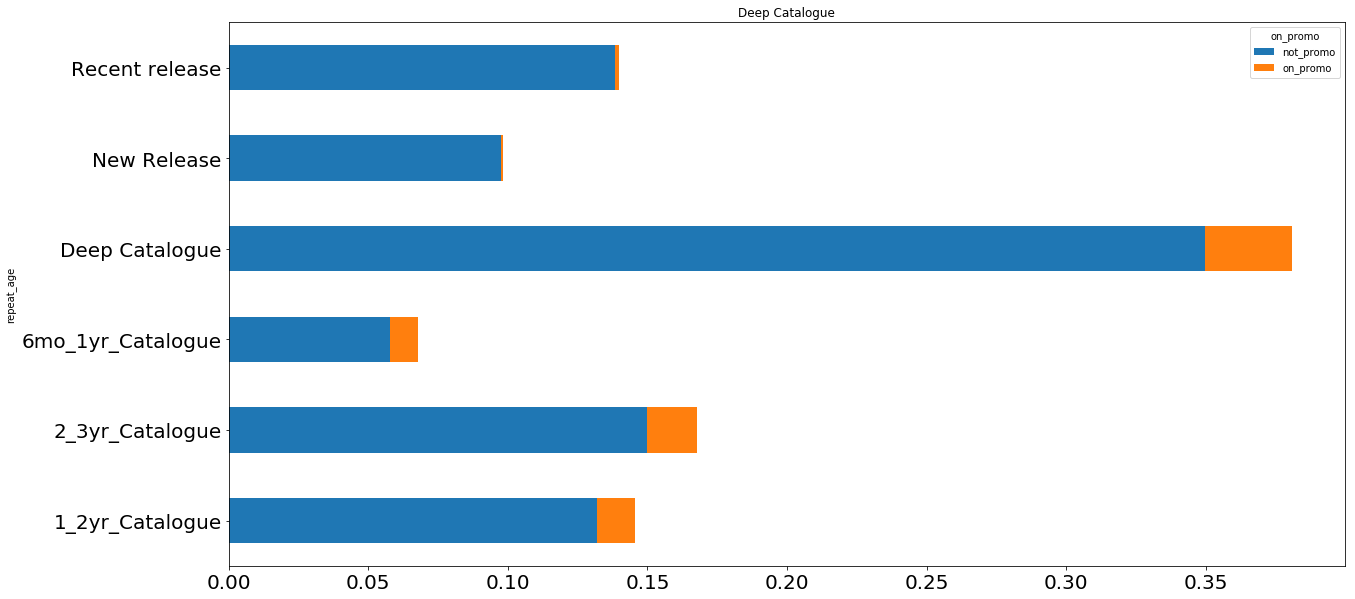

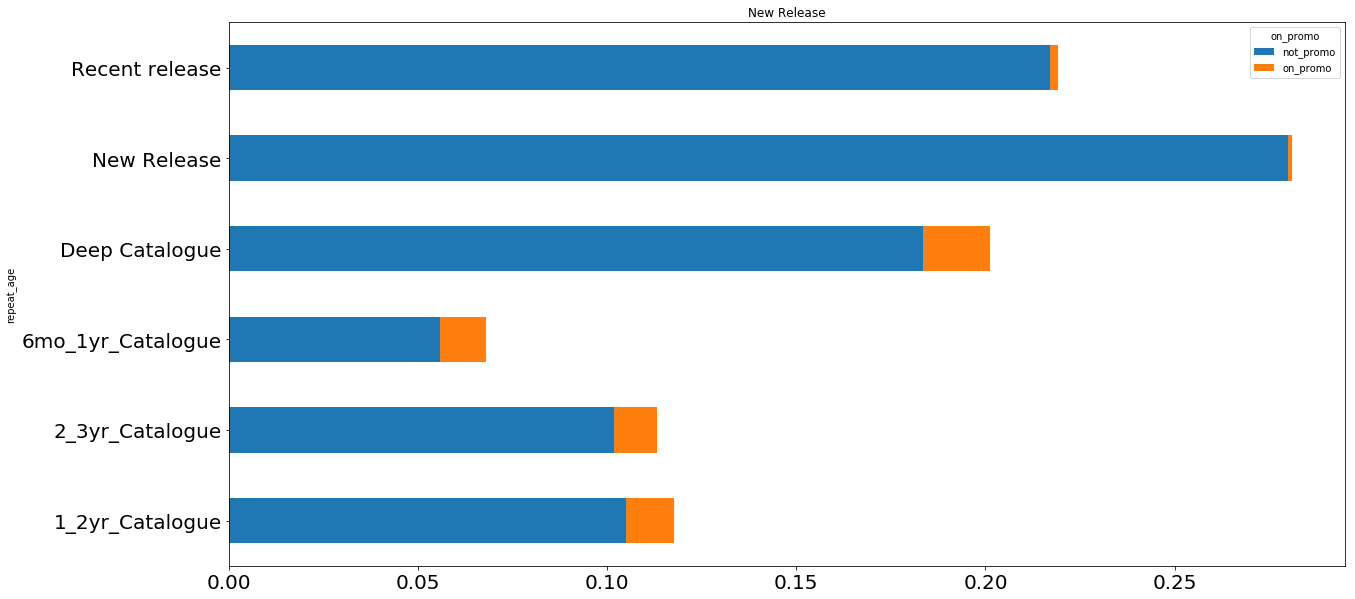

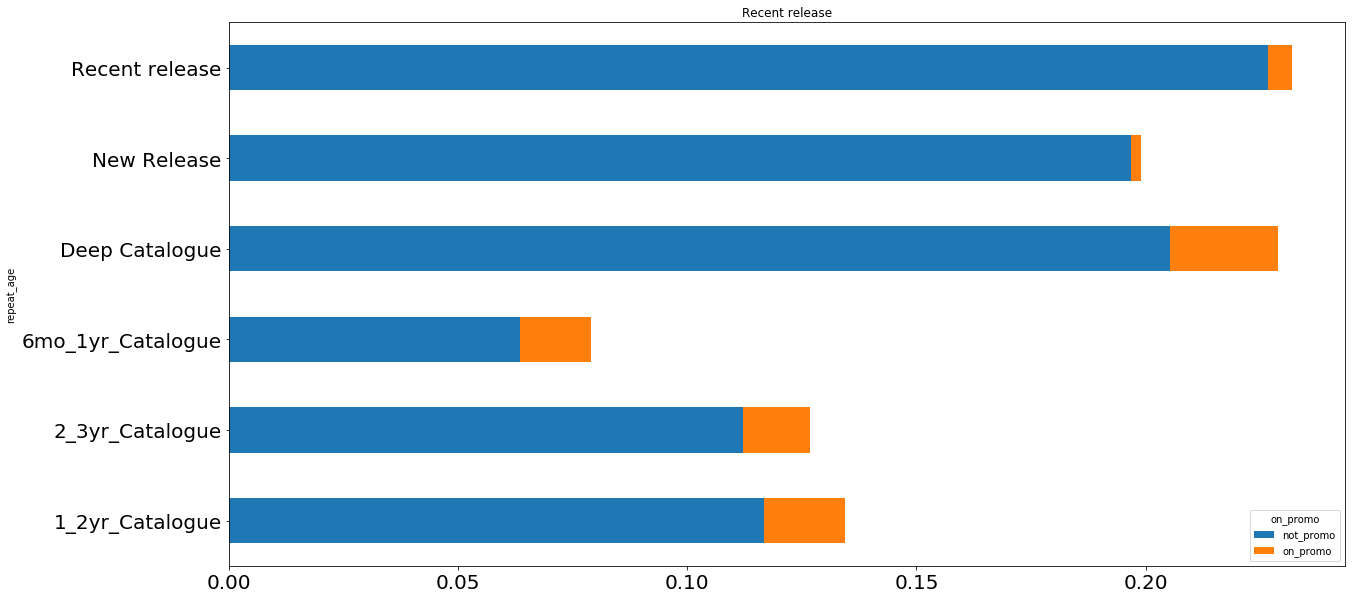

In [544]:
d = t[t['returning_month'] == '2017-12-01']

for title, group in d.groupby('age'):
    pivot = group.pivot( index = 'repeat_age', columns='on_promo',values='per')
    pivot.plot.barh(stacked=True, title=title,figsize = (20,10), fontsize = 20)


# Add content type layer to content age

In [476]:
ch.head()

,customer_Id,start_month,type,age,first_price,returning_month,repeat_type,repeat_age,transaction_date_local,repeat_price,last2from_repeat,on_promo
0,20341153225,2017-10-01,Movie,Deep Catalogue,3.99,2017-11-01,Movie,Deep Catalogue,2017-11-23,1.99,0.99,not_promo
1,10400687,2017-10-01,Movie,Recent release,NaN,2017-11-01,Movie,Recent release,2017-11-24,0.99,0.99,not_promo
2,6745944725,2017-10-01,TV Season,Recent release,18.99,2017-11-01,Movie,Recent release,2017-11-24,0.99,0.99,not_promo
3,12872057625,2017-10-01,Movie,2_3yr_Catalogue,2.99,2017-12-01,Movie,6mo_1yr_Catalogue,2017-12-02,3.99,0.99,not_promo
4,15972159535,2017-10-01,Movie,Recent release,12.99,2017-12-01,Movie,Recent release,2017-12-07,4.99,0.99,not_promo


In [477]:
age_first = pd.DataFrame(ch.groupby("age")['customer_Id'].nunique().reset_index())
age_first['pcts'] = age_first['customer_Id'] / age_first['customer_Id'].sum()
age_first

,age,customer_Id,pcts
0,1_2yr_Catalogue,27529,0.149334
1,2_3yr_Catalogue,27848,0.151065
2,6mo_1yr_Catalogue,17032,0.092392
3,Deep Catalogue,43705,0.237083
4,New Release,23495,0.127451
5,Recent release,44736,0.242675


In [478]:
age_type_first = pd.DataFrame(ch.groupby(["age",'type'])['customer_Id'].nunique().reset_index())
age_type_first['concat'] = age_type_first[['age','type']].apply(lambda x: "__".join(x),axis = 1)
age_type_first['pcts'] = age_type_first['customer_Id'] / age_type_first['customer_Id'].sum()
age_type_first

,age,type,customer_Id,concat,pcts
0,1_2yr_Catalogue,Movie,21542,1_2yr_Catalogue__Movie,0.116857
1,1_2yr_Catalogue,TV Episode,2621,1_2yr_Catalogue__TV Episode,0.014218
2,1_2yr_Catalogue,TV Season,3366,1_2yr_Catalogue__TV Season,0.018259
3,2_3yr_Catalogue,Movie,24533,2_3yr_Catalogue__Movie,0.133082
4,2_3yr_Catalogue,TV Episode,1721,2_3yr_Catalogue__TV Episode,0.009336
5,2_3yr_Catalogue,TV Season,1594,2_3yr_Catalogue__TV Season,0.008647
6,6mo_1yr_Catalogue,Movie,11633,6mo_1yr_Catalogue__Movie,0.063105
7,6mo_1yr_Catalogue,TV Episode,2179,6mo_1yr_Catalogue__TV Episode,0.011820
8,6mo_1yr_Catalogue,TV Season,3220,6mo_1yr_Catalogue__TV Season,0.017467
9,Deep Catalogue,Movie,39200,Deep Catalogue__Movie,0.212645


Distribution of OPS per content age and content type


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F2296B8FD0>], dtype=object)

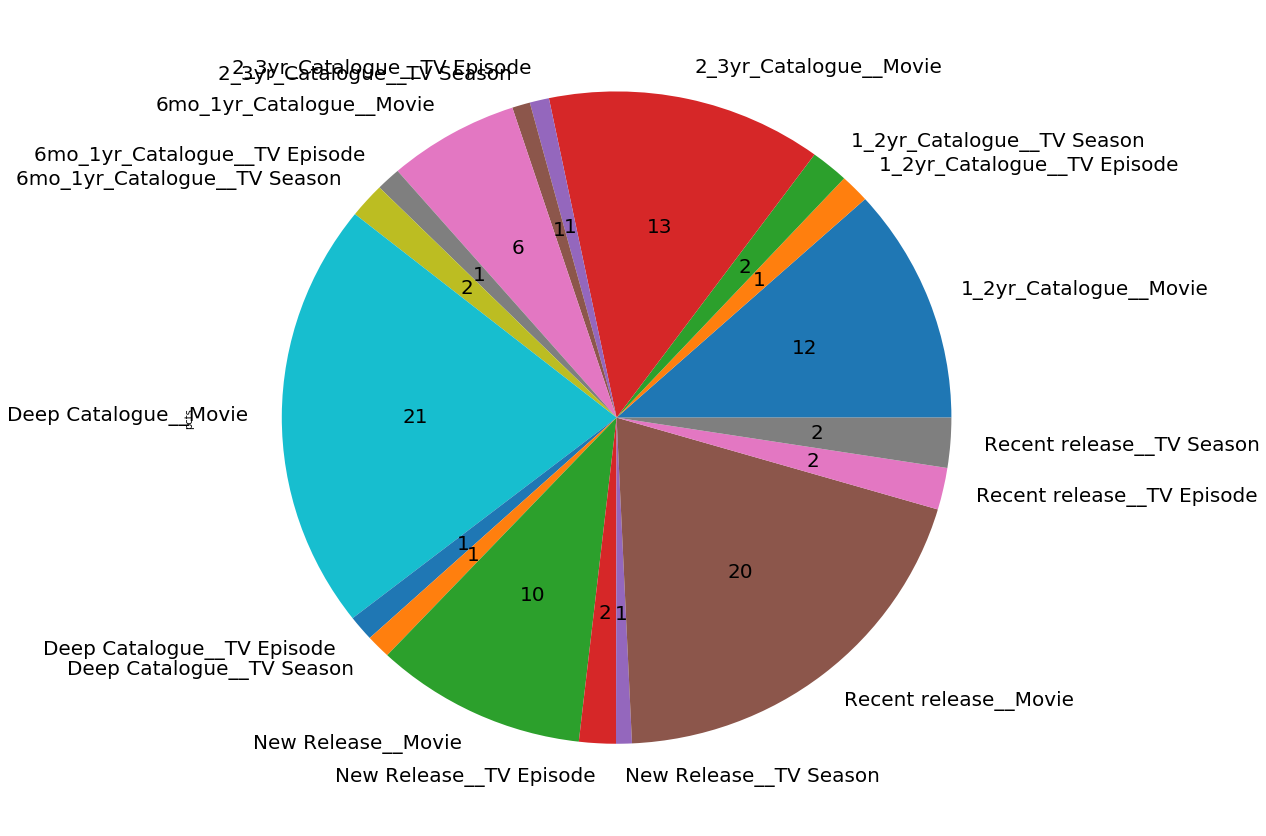

In [508]:
print("Distribution of OPS per content age and content type")
age_type_first['pcts'].plot.pie(subplots=True, figsize=(15, 15), 
                           labels= age_type_first.concat, autopct='%.0f',fontsize=20)